# Import required modules
Make sure you installed the conda environment and activated it first by running:

```
conda env create -f env.yml
```

Then you can choose that environment for the jupyter kernel.

## Important!!
If you want to use the witwidget and haven't already run these commands you must do so!

```
jupyter nbextension install --py --symlink --sys-prefix witwidget
jupyter nbextension enable --py --sys-prefix witwidget
```

In [1]:
import multiprocessing
import os

import numpy as np
import pandas as pd
import shap
import tensorflow as tf
from sklearn import linear_model, metrics, model_selection

# Load data and make required directories

In [2]:
dat_in_pth = "../data/features.pkl"
dat_df = pd.read_pickle(dat_in_pth)

results_dir = "results"
seed = 8675309
np.random.seed(seed)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

training_set_tss_ids_pth = results_dir + "/training_set_tss_ids.txt"
heldout_test_set_tss_ids_pth = results_dir + "/heldout_test_set_tss_ids.txt"
crossval_results_pth = results_dir + "/crossval_results.csv"
test_performance_pth = results_dir + "/heldout_test_performance.csv"
coefs_pth = results_dir + "/coefficients.csv"

dat_df.head()

,M0004_1.02_FWD_1,M0004_1.02_FWD_2,M0004_1.02_FWD_3,M0004_1.02_FWD_4,M0004_1.02_FWD_5,M0004_1.02_FWD_6,M0004_1.02_FWD_7,M0005_1.02_FWD_1,M0005_1.02_FWD_2,M0005_1.02_FWD_3,...,GA_REV_2,GA_REV_3,GA_REV_4,GA_REV_5,GA_REV_6,GA_REV_7,GCcontent,CAcontent,GAcontent,class
index,,,,,,,,,,,,,,,,,,,,,
Chr4_+_7750398_AT4G13310_root_0,1.440441,0.000000,0.000000,4.508889,9.438149,9.714371,17.533581,5.501110,0.0,0.0,...,11.805773,9.450124,12.967102,8.974781,14.424215,13.597577,0.300,0.590,0.580,1
Chr4_+_11302680_AT4G21200_leaf_0,11.111250,11.111250,0.000000,0.000000,12.846526,16.472290,5.290287,2.406347,0.0,0.0,...,0.824729,9.927819,16.496307,6.568488,4.865940,4.865940,0.340,0.540,0.430,1
Chr4_-_10918262_AT4G20210_root_0,0.293377,4.510425,4.217049,4.559656,5.156968,0.597312,0.000000,0.000000,0.0,0.0,...,2.222053,11.242960,9.343733,6.638287,25.419486,18.781199,0.410,0.545,0.475,1
Chr5_-_26757236_AT5G67030_tair_0,0.555420,2.275065,2.275065,0.000000,0.000000,0.189317,22.804014,0.000000,0.0,0.0,...,9.204328,3.095468,0.000000,11.282284,13.337318,11.061596,0.425,0.495,0.440,1
Chr1_-_25046860_AT1G67080_tair_0,0.000000,1.398959,1.398959,1.377300,2.470973,1.093673,0.000000,0.000000,0.0,0.0,...,11.599996,10.826384,11.891774,11.529227,11.948718,8.528950,0.305,0.545,0.550,1


# Split data into train/test sets

In [3]:
train, heldout_test = model_selection.train_test_split(
    dat_df, test_size=0.2, stratify=dat_df["class"], random_state=seed
)

np.savetxt(training_set_tss_ids_pth, train.index.values, fmt="%s")
np.savetxt(heldout_test_set_tss_ids_pth, heldout_test.index.values, fmt="%s")

# Define model object
* Change `n_procs` to utilize more/fewer processors on your machine

In [4]:
n_procs = 10

log_cv = linear_model.LogisticRegressionCV(
    solver="liblinear",
    Cs=np.logspace(-4, 4, 100),
    cv=5,
    penalty="l1",
    n_jobs=n_procs,
    refit=True,
    scoring="average_precision",
    random_state=seed,
)

# Fit the model on training data

In [5]:
log_cv.fit(train.iloc[:, :-1], y=train["class"])

LogisticRegressionCV(Cs=array([1.00000000e-04, 1.20450354e-04, 1.45082878e-04, 1.74752840e-04,
       2.10490414e-04, 2.53536449e-04, 3.05385551e-04, 3.67837977e-04,
       4.43062146e-04, 5.33669923e-04, 6.42807312e-04, 7.74263683e-04,
       9.32603347e-04, 1.12332403e-03, 1.35304777e-03, 1.62975083e-03,
       1.96304065e-03, 2.36448941e-03, 2.84803587e-03, 3.43046929e-03,
       4.13201240e-03, 4.97...
       2.91505306e+02, 3.51119173e+02, 4.22924287e+02, 5.09413801e+02,
       6.13590727e+02, 7.39072203e+02, 8.90215085e+02, 1.07226722e+03,
       1.29154967e+03, 1.55567614e+03, 1.87381742e+03, 2.25701972e+03,
       2.71858824e+03, 3.27454916e+03, 3.94420606e+03, 4.75081016e+03,
       5.72236766e+03, 6.89261210e+03, 8.30217568e+03, 1.00000000e+04]),
                     cv=5, n_jobs=10, penalty='l1', random_state=8675309,
                     scoring='average_precision', solver='liblinear')

# Test the model

In [6]:
y_true, y_prediction_probabilities = (
    heldout_test["class"],
    log_cv.predict_proba(heldout_test.iloc[:, :-1]),
)

# SHAP Explanations

In [7]:
explainer = shap.LinearExplainer(log_cv, train.iloc[:, :-1])
shap_values = explainer.shap_values(heldout_test.iloc[:, :-1])

## SHAP Values for entire test set

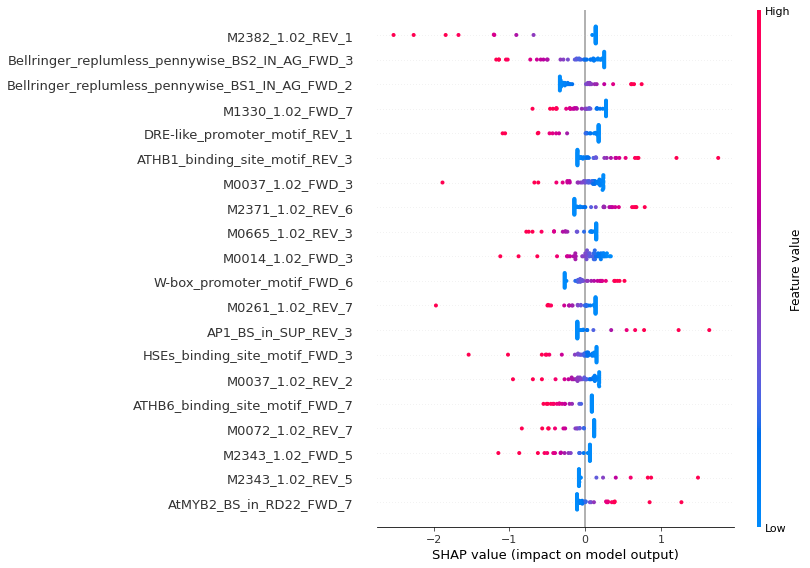

In [8]:
shap.summary_plot(shap_values, heldout_test.iloc[:, :-1])

## SHAP values for single instance

In [9]:
ind = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[ind], heldout_test.iloc[ind, :-1])

# Compute performance metrics for predictions on the test set

In [7]:
roc_curve_df = (
    pd.DataFrame(metrics.roc_curve(y_true, y_prediction_probabilities[:, 1]))
    .T.rename(columns={0: "FPR", 1: "TPR", 2: "threshold"})
    .drop(index=0)
    .reset_index(drop=True)
)
roc_curve_df["Y"] = roc_curve_df["TPR"] - roc_curve_df["FPR"]
youden_T = roc_curve_df.iloc[roc_curve_df["Y"].idxmax()]["threshold"]

y_pred_youden = np.where(y_prediction_probabilities[:, 1] >= youden_T, 1, 0)

heldout_perf_roc = metrics.roc_auc_score(y_true, y_prediction_probabilities[:, 1])
heldout_perf_prc = metrics.average_precision_score(
    y_true, y_prediction_probabilities[:, 1]
)

confusion_mat = metrics.confusion_matrix(y_true, y_pred_youden)
TN = confusion_mat[0][0]
FP = confusion_mat[0][1]
FN = confusion_mat[1][0]
TP = confusion_mat[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP / (TP + FN)
# Specificity or true negative rate
TNR = TN / (TN + FP)
# Precision or positive predictive value
PPV = TP / (TP + FP)

heldout_perf_f1 = 2 * ((PPV * TPR) / (PPV + TPR))

perf_metrics = pd.Series({
    "C": log_cv.C_[0],
    "auROC": heldout_perf_roc,
    "auPRC": heldout_perf_prc,
    "youden_T": youden_T,
    "sensitivity": TPR,
    "specificity": TNR,
    "precision": PPV,
    "f1": heldout_perf_f1,
    "seed": seed,
})
perf_metrics

C              4.750810e+03
auROC          6.952663e-01
auPRC          6.470624e-01
youden_T       5.342641e-01
sensitivity    7.307692e-01
specificity    6.538462e-01
precision      6.785714e-01
f1             7.037037e-01
seed           8.675309e+06
dtype: float64

In [8]:
coefficients = pd.DataFrame(log_cv.coef_, columns=dat_df.columns[:-1])
coefficients

,M0004_1.02_FWD_1,M0004_1.02_FWD_2,M0004_1.02_FWD_3,M0004_1.02_FWD_4,M0004_1.02_FWD_5,M0004_1.02_FWD_6,M0004_1.02_FWD_7,M0005_1.02_FWD_1,M0005_1.02_FWD_2,M0005_1.02_FWD_3,...,GA_REV_1,GA_REV_2,GA_REV_3,GA_REV_4,GA_REV_5,GA_REV_6,GA_REV_7,GCcontent,CAcontent,GAcontent
0,0.000448,0.0,-0.007917,-0.001143,0.004216,-0.007482,-0.004137,0.0,-0.000461,-0.039019,...,0.004723,-0.002895,-0.00155,0.002511,0.004984,0.006744,0.002118,0.0,0.0,0.0


# Save files

In [9]:
# save metrics
perf_metrics.to_csv(test_performance_pth, header=True)

# save coefficient values
coefficients.to_csv(coefs_pth, header=True)